# Week 4: Using real world data

Welcome! So far you have worked exclusively with generated data. This time you will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs you will also use Convolutional layers to improve the model's performance.

Let's get started!

In [7]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

Begin by looking at the structure of the csv that contains the data:

In [8]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



As you can see, each data point is composed of the date and the recorded minimum temperature for that date.


In the first exercise you will code a function to read the data from the csv but for now run the next cell to load a helper function to plot the time series.

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data
Now you need to read the data from the csv file. To do so, complete the `parse_data_from_file` function.

A couple of things to note:

- You should omit the first line as the file contains headers.
- There is no need to save the data points as numpy arrays, regular lists is fine.
- To read from csv files use `csv.reader` by passing the appropriate arguments.
- `csv.reader` returns an iterable that returns each row in every iteration. So the temperature can be accessed via row[1] and the date can be discarded.
- The `times` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `temperatures` list.
- The values of the `temperatures` should be of `float` type. You can use Python's built-in `float` function to ensure this.

In [18]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        ### START CODE HERE
        
        reader = csv.reader(csvfile, delimiter=',')
        
        # Skip the first line
        next(reader)
        for index,row in enumerate(reader):
            times.append(index)
            temperatures.append(float(row[1]))
        ### END CODE HERE
            
    return times, temperatures


The next cell will use your function to compute the `times` and `temperatures` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

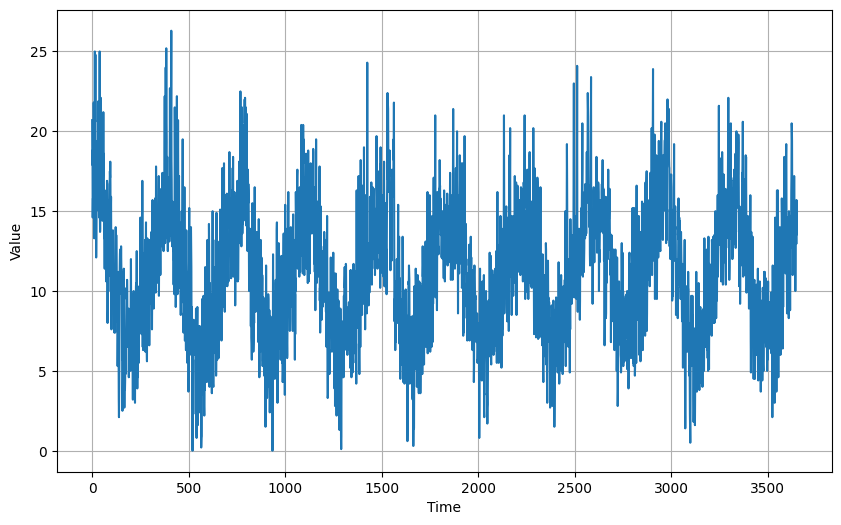

In [20]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

**Expected Output:**
<div>
<img src="images/temp-series.png" width="500"/>
</div>

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:

In [21]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [23]:
len(time_train)

2500

In [22]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define your layer architecture. Just as in last week's assignment you will do the layer definition and compilation in two separate steps. Begin by completing the `create_uncompiled_model` function below.

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:

- `Lambda` layers are not required.
- Use a combination of `Conv1D` and `LSTM` layers followed by `Dense` layers

In [29]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=50, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[G.WINDOW_SIZE, 1]),
      tf.keras.layers.LSTM(50, return_sequences=True),
      tf.keras.layers.LSTM(50),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1)  
    ]) 
    
    ### END CODE HERE

    return model

In [30]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()
uncompiled_model.summary()
try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

/Users/civye1/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 50)         │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,451 (165.82 KB)

 Trainable params: 42,451 (165.82 KB)

 Non-trainable params: 0 (0.00 B)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Your current architecture is compatible with the windowed dataset! :)


2024-07-13 14:31:37.742844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/civye1/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lecture you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [31]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [32]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100


/Users/civye1/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.0501 - mae: 9.5488 - learning_rate: 1.0000e-04
Epoch 2/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.4530 - mae: 7.9401

2024-07-13 14:35:47.945787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/civye1/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.3239 - mae: 6.8139 - learning_rate: 1.1220e-04
Epoch 3/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9007 - mae: 3.3765

2024-07-13 14:35:49.445670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6558 - mae: 3.1251 - learning_rate: 1.2589e-04
Epoch 4/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4197 - mae: 2.8796

2024-07-13 14:35:50.937400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.2737 - mae: 2.7322 - learning_rate: 1.4125e-04
Epoch 5/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.1407 - mae: 2.5978

2024-07-13 14:35:52.442899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9478 - mae: 2.4024 - learning_rate: 1.5849e-04
Epoch 6/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7137 - mae: 2.1727

2024-07-13 14:35:53.926837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8513 - mae: 2.3056 - learning_rate: 1.7783e-04
Epoch 7/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9263 - mae: 2.3731

2024-07-13 14:35:55.418606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8278 - mae: 2.2776 - learning_rate: 1.9953e-04
Epoch 8/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6260 - mae: 2.0666

2024-07-13 14:35:56.915068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8178 - mae: 2.2654 - learning_rate: 2.2387e-04
Epoch 9/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9995 - mae: 2.4751

2024-07-13 14:35:58.409921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8575 - mae: 2.3150 - learning_rate: 2.5119e-04
Epoch 10/100
 4/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9020 - mae: 2.3653 

2024-07-13 14:35:59.907501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.8040 - mae: 2.2599 - learning_rate: 2.8184e-04
Epoch 11/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7480 - mae: 2.1951

2024-07-13 14:36:01.461782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7508 - mae: 2.2011 - learning_rate: 3.1623e-04
Epoch 12/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8425 - mae: 2.2862

2024-07-13 14:36:02.968641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8053 - mae: 2.2581 - learning_rate: 3.5481e-04
Epoch 13/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8159 - mae: 2.2638

2024-07-13 14:36:04.464701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7694 - mae: 2.2239 - learning_rate: 3.9811e-04
Epoch 14/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0114 - mae: 2.4679

2024-07-13 14:36:05.945362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8319 - mae: 2.2841 - learning_rate: 4.4668e-04
Epoch 15/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6038 - mae: 2.0493

2024-07-13 14:36:07.442515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6551 - mae: 2.1025 - learning_rate: 5.0119e-04
Epoch 16/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4942 - mae: 1.9433

2024-07-13 14:36:08.939542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6858 - mae: 2.1371 - learning_rate: 5.6234e-04
Epoch 17/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7842 - mae: 2.2418

2024-07-13 14:36:10.429268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6887 - mae: 2.1398 - learning_rate: 6.3096e-04
Epoch 18/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8066 - mae: 2.2705

2024-07-13 14:36:11.939761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7044 - mae: 2.1539 - learning_rate: 7.0795e-04
Epoch 19/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.8644 - mae: 2.3138

2024-07-13 14:36:13.447647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.6317 - mae: 2.0758 - learning_rate: 7.9433e-04
Epoch 20/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5233 - mae: 1.9567

2024-07-13 14:36:15.013770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5932 - mae: 2.0327 - learning_rate: 8.9125e-04
Epoch 21/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5813 - mae: 2.0184

2024-07-13 14:36:16.518272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5804 - mae: 2.0217 - learning_rate: 0.0010
Epoch 22/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6533 - mae: 2.1056

2024-07-13 14:36:18.022799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6263 - mae: 2.0714 - learning_rate: 0.0011
Epoch 23/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7638 - mae: 2.1981

2024-07-13 14:36:19.530840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6100 - mae: 2.0520 - learning_rate: 0.0013
Epoch 24/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8833 - mae: 2.3333

2024-07-13 14:36:21.028924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6665 - mae: 2.1129 - learning_rate: 0.0014
Epoch 25/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2567 - mae: 1.6770

2024-07-13 14:36:22.509355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5146 - mae: 1.9533 - learning_rate: 0.0016
Epoch 26/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6334 - mae: 2.0866

2024-07-13 14:36:23.997809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6362 - mae: 2.0863 - learning_rate: 0.0018
Epoch 27/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.4624 - mae: 1.9066

2024-07-13 14:36:25.489958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5945 - mae: 2.0404 - learning_rate: 0.0020
Epoch 28/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6530 - mae: 2.1093

2024-07-13 14:36:26.971065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6091 - mae: 2.0559 - learning_rate: 0.0022
Epoch 29/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.6352 - mae: 2.0771

2024-07-13 14:36:28.459659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6400 - mae: 2.0886 - learning_rate: 0.0025
Epoch 30/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6835 - mae: 2.1440

2024-07-13 14:36:29.974393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6210 - mae: 2.0693 - learning_rate: 0.0028
Epoch 31/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8667 - mae: 2.3169

2024-07-13 14:36:31.450001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6484 - mae: 2.0970 - learning_rate: 0.0032
Epoch 32/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8989 - mae: 2.3442

2024-07-13 14:36:32.947231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6999 - mae: 2.1454 - learning_rate: 0.0035
Epoch 33/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5757 - mae: 2.0091

2024-07-13 14:36:34.429358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5696 - mae: 2.0088 - learning_rate: 0.0040
Epoch 34/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7217 - mae: 2.1877

2024-07-13 14:36:35.913058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7088 - mae: 2.1639 - learning_rate: 0.0045
Epoch 35/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9432 - mae: 2.3810

2024-07-13 14:36:37.391135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6352 - mae: 2.0741 - learning_rate: 0.0050
Epoch 36/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.8320 - mae: 2.2784

2024-07-13 14:36:38.869194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7099 - mae: 2.1561 - learning_rate: 0.0056
Epoch 37/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8141 - mae: 2.2744

2024-07-13 14:36:40.354217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6681 - mae: 2.1172 - learning_rate: 0.0063
Epoch 38/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9688 - mae: 2.4309

2024-07-13 14:36:41.830451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8597 - mae: 2.3129 - learning_rate: 0.0071
Epoch 39/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5013 - mae: 1.9245

2024-07-13 14:36:43.318260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6339 - mae: 2.0728 - learning_rate: 0.0079
Epoch 40/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7583 - mae: 2.2147

2024-07-13 14:36:44.812600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7194 - mae: 2.1689 - learning_rate: 0.0089
Epoch 41/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8148 - mae: 2.2682

2024-07-13 14:36:46.303801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7337 - mae: 2.1820 - learning_rate: 0.0100
Epoch 42/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6664 - mae: 2.1054

2024-07-13 14:36:47.799940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7027 - mae: 2.1489 - learning_rate: 0.0112
Epoch 43/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.8177 - mae: 2.2645

2024-07-13 14:36:49.287618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7462 - mae: 2.1888 - learning_rate: 0.0126
Epoch 44/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5718 - mae: 2.0156

2024-07-13 14:36:50.765483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7152 - mae: 2.1659 - learning_rate: 0.0141
Epoch 45/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7439 - mae: 2.2031

2024-07-13 14:36:52.252160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7615 - mae: 2.2170 - learning_rate: 0.0158
Epoch 46/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7800 - mae: 2.2336

2024-07-13 14:36:53.729503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7046 - mae: 2.1494 - learning_rate: 0.0178
Epoch 47/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7498 - mae: 2.2103

2024-07-13 14:36:55.237721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.1195 - mae: 2.5829 - learning_rate: 0.0200
Epoch 48/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7908 - mae: 3.2558

2024-07-13 14:36:56.734774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.1050 - mae: 2.5600 - learning_rate: 0.0224
Epoch 49/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.6536 - mae: 2.0946

2024-07-13 14:36:58.227349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8043 - mae: 2.2527 - learning_rate: 0.0251
Epoch 50/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9242 - mae: 2.3710

2024-07-13 14:36:59.715527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8373 - mae: 2.2874 - learning_rate: 0.0282
Epoch 51/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6774 - mae: 2.1263

2024-07-13 14:37:01.194577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.7715 - mae: 2.2179 - learning_rate: 0.0316
Epoch 52/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7051 - mae: 2.1490

2024-07-13 14:37:02.784124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7742 - mae: 2.2244 - learning_rate: 0.0355
Epoch 53/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0943 - mae: 2.5541

2024-07-13 14:37:04.269231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.1766 - mae: 2.6376 - learning_rate: 0.0398
Epoch 54/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7227 - mae: 2.1689

2024-07-13 14:37:05.777768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9777 - mae: 2.4324 - learning_rate: 0.0447
Epoch 55/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.8384 - mae: 3.2994

2024-07-13 14:37:07.251586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4606 - mae: 2.9237 - learning_rate: 0.0501
Epoch 56/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.2285 - mae: 2.6765

2024-07-13 14:37:08.731721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0319 - mae: 2.4866 - learning_rate: 0.0562
Epoch 57/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4021 - mae: 2.8556

2024-07-13 14:37:10.210068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.3765 - mae: 2.8361 - learning_rate: 0.0631
Epoch 58/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.1571 - mae: 2.5966

2024-07-13 14:37:11.699310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.2952 - mae: 2.7508 - learning_rate: 0.0708
Epoch 59/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.2708 - mae: 2.7354

2024-07-13 14:37:13.193139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4470 - mae: 2.9102 - learning_rate: 0.0794
Epoch 60/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.2074 - mae: 2.6640

2024-07-13 14:37:14.674858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.1976 - mae: 2.6527 - learning_rate: 0.0891
Epoch 61/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.0112 - mae: 3.4737

2024-07-13 14:37:16.159914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9210 - mae: 3.3892 - learning_rate: 0.1000
Epoch 62/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.4416 - mae: 3.9261

2024-07-13 14:37:17.644406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9446 - mae: 3.4169 - learning_rate: 0.1122
Epoch 63/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6959 - mae: 3.1585

2024-07-13 14:37:19.128495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8297 - mae: 3.2954 - learning_rate: 0.1259
Epoch 64/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6710 - mae: 3.1362

2024-07-13 14:37:20.620846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7469 - mae: 3.2128 - learning_rate: 0.1413
Epoch 65/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.1451 - mae: 3.6154

2024-07-13 14:37:22.098294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.8638 - mae: 3.3313 - learning_rate: 0.1585
Epoch 66/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8787 - mae: 3.3528

2024-07-13 14:37:23.637092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7730 - mae: 3.2400 - learning_rate: 0.1778
Epoch 67/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8738 - mae: 3.3460

2024-07-13 14:37:25.128344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7989 - mae: 3.2665 - learning_rate: 0.1995
Epoch 68/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7336 - mae: 3.2061

2024-07-13 14:37:26.626770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7970 - mae: 3.2657 - learning_rate: 0.2239
Epoch 69/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9157 - mae: 3.3845

2024-07-13 14:37:28.125141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7968 - mae: 3.2633 - learning_rate: 0.2512
Epoch 70/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.1741 - mae: 3.6537

2024-07-13 14:37:29.607533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.8660 - mae: 3.3373 - learning_rate: 0.2818
Epoch 71/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0313 - mae: 3.5024

2024-07-13 14:37:31.108197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.8400 - mae: 3.3103 - learning_rate: 0.3162
Epoch 72/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0011 - mae: 3.4680

2024-07-13 14:37:32.707096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.8703 - mae: 3.3383 - learning_rate: 0.3548
Epoch 73/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.7952 - mae: 3.2656

2024-07-13 14:37:34.326114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.8517 - mae: 3.3199 - learning_rate: 0.3981
Epoch 74/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.0419 - mae: 3.5165

2024-07-13 14:37:35.885907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.8455 - mae: 3.3141 - learning_rate: 0.4467
Epoch 75/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0771 - mae: 3.5538

2024-07-13 14:37:37.476169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.8769 - mae: 3.3467 - learning_rate: 0.5012
Epoch 76/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.6850 - mae: 3.1487

2024-07-13 14:37:39.116687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.8213 - mae: 3.2868 - learning_rate: 0.5623
Epoch 77/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8298 - mae: 3.2989

2024-07-13 14:37:40.766002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8840 - mae: 3.3533 - learning_rate: 0.6310
Epoch 78/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9612 - mae: 3.4336

2024-07-13 14:37:42.258509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9324 - mae: 3.3993 - learning_rate: 0.7079
Epoch 79/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9659 - mae: 3.4378

2024-07-13 14:37:43.745969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9245 - mae: 3.3942 - learning_rate: 0.7943
Epoch 80/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7820 - mae: 3.2676

2024-07-13 14:37:45.235606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8424 - mae: 3.3165 - learning_rate: 0.8913
Epoch 81/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9128 - mae: 3.3618

2024-07-13 14:37:46.716106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9715 - mae: 3.4384 - learning_rate: 1.0000
Epoch 82/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.4590 - mae: 3.9416

2024-07-13 14:37:48.193080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.0451 - mae: 3.5218 - learning_rate: 1.1220
Epoch 83/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8073 - mae: 3.2780

2024-07-13 14:37:49.703041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.8465 - mae: 3.3168 - learning_rate: 1.2589
Epoch 84/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.3878 - mae: 3.8657

2024-07-13 14:37:51.255923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.0914 - mae: 3.5626 - learning_rate: 1.4125
Epoch 85/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.8126 - mae: 3.2781

2024-07-13 14:37:52.974087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.0076 - mae: 3.4785 - learning_rate: 1.5849
Epoch 86/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.4403 - mae: 3.9063

2024-07-13 14:37:54.541752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.1395 - mae: 3.6112 - learning_rate: 1.7783
Epoch 87/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7896 - mae: 3.2664

2024-07-13 14:37:56.071328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.8297 - mae: 3.3006 - learning_rate: 1.9953
Epoch 88/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.5396 - mae: 2.9878

2024-07-13 14:37:57.576474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.9179 - mae: 3.3852 - learning_rate: 2.2387
Epoch 89/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.5569 - mae: 4.0159

2024-07-13 14:37:59.080782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.3151 - mae: 3.7855 - learning_rate: 2.5119
Epoch 90/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.5667 - mae: 3.0305

2024-07-13 14:38:00.590597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.7777 - mae: 3.2468 - learning_rate: 2.8184
Epoch 91/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.3241 - mae: 3.7920

2024-07-13 14:38:02.170860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.1579 - mae: 3.6285 - learning_rate: 3.1623
Epoch 92/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.0090 - mae: 3.4794

2024-07-13 14:38:03.762565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9919 - mae: 3.4613 - learning_rate: 3.5481
Epoch 93/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7816 - mae: 3.2243

2024-07-13 14:38:05.255595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.2009 - mae: 3.6699 - learning_rate: 3.9811
Epoch 94/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.6488 - mae: 4.1264

2024-07-13 14:38:06.739660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.3339 - mae: 3.8059 - learning_rate: 4.4668
Epoch 95/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.1970 - mae: 3.6729

2024-07-13 14:38:08.232533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.0467 - mae: 3.5176 - learning_rate: 5.0119
Epoch 96/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.3312 - mae: 3.8115

2024-07-13 14:38:09.727030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.4217 - mae: 3.8981 - learning_rate: 5.6234
Epoch 97/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.3673 - mae: 3.8417

2024-07-13 14:38:11.243797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.3304 - mae: 3.8039 - learning_rate: 6.3096
Epoch 98/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.5150 - mae: 3.9927

2024-07-13 14:38:12.736634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.4015 - mae: 3.8763 - learning_rate: 7.0795
Epoch 99/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.3328 - mae: 3.8092

2024-07-13 14:38:14.245677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.0668 - mae: 3.5385 - learning_rate: 7.9433
Epoch 100/100
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.4929 - mae: 4.9678

2024-07-13 14:38:15.750454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.9872 - mae: 4.4651 - learning_rate: 8.9125


2024-07-13 14:38:17.242197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(0.0002, 0.1, 0.0, 10.0)

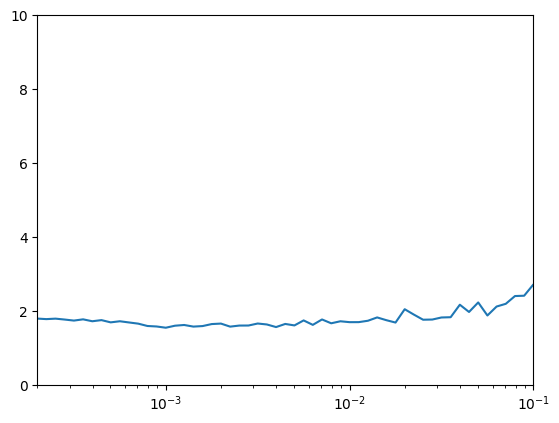

In [37]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([2e-4, 1e-1, 0, 10])

## Compiling the model
Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hints:

- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: loss: nan - mae: nan it is very likely that your network is suffering from exploding gradients. This is a common problem if you used SGD as optimizer and set a learning rate that is too high. If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.

In [38]:
def create_model():

    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=6e-4 ),
                  metrics=["mae"])  
    

    ### END CODE HERE

    return model

In [39]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50


/Users/civye1/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.8512 - mae: 10.3499
Epoch 2/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.8170 - mae: 4.2826

2024-07-13 14:44:10.649353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/civye1/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.0352 - mae: 3.5011
Epoch 3/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.3256 - mae: 2.7946

2024-07-13 14:44:12.174464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.2580 - mae: 2.7211
Epoch 4/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.3118 - mae: 2.7784

2024-07-13 14:44:13.710573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.1601 - mae: 2.6157
Epoch 5/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8708 - mae: 2.3179

2024-07-13 14:44:15.256611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.8693 - mae: 2.3224
Epoch 6/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0206 - mae: 2.4820

2024-07-13 14:44:16.786115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.8298 - mae: 2.2837
Epoch 7/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0488 - mae: 2.5116

2024-07-13 14:44:18.322661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.9445 - mae: 2.3993
Epoch 8/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.1985 - mae: 2.6612

2024-07-13 14:44:19.853270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.8560 - mae: 2.3098
Epoch 9/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9377 - mae: 2.3969

2024-07-13 14:44:21.381409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7896 - mae: 2.2423
Epoch 10/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8948 - mae: 2.3424

2024-07-13 14:44:22.900376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7118 - mae: 2.1585
Epoch 11/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9171 - mae: 2.3829

2024-07-13 14:44:24.423555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6775 - mae: 2.1281
Epoch 12/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5332 - mae: 1.9866

2024-07-13 14:44:25.944404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.6399 - mae: 2.0869
Epoch 13/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8233 - mae: 2.2676

2024-07-13 14:44:27.528388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6673 - mae: 2.1115
Epoch 14/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4951 - mae: 1.9520

2024-07-13 14:44:29.058863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6621 - mae: 2.1115
Epoch 15/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4940 - mae: 1.9378

2024-07-13 14:44:30.600351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5768 - mae: 2.0194
Epoch 16/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6293 - mae: 2.0800

2024-07-13 14:44:32.130724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5873 - mae: 2.0312
Epoch 17/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6347 - mae: 2.0700

2024-07-13 14:44:33.653277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.6349 - mae: 2.0803
Epoch 18/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7232 - mae: 2.1702

2024-07-13 14:44:35.245386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.6027 - mae: 2.0477
Epoch 19/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5100 - mae: 1.9269

2024-07-13 14:44:36.831460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5321 - mae: 1.9709
Epoch 20/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4557 - mae: 1.8986

2024-07-13 14:44:38.365947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5805 - mae: 2.0236
Epoch 21/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5578 - mae: 1.9888

2024-07-13 14:44:39.904339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5985 - mae: 2.0416
Epoch 22/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5465 - mae: 1.9939

2024-07-13 14:44:41.422490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5157 - mae: 1.9600
Epoch 23/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7477 - mae: 2.2059

2024-07-13 14:44:42.952464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6250 - mae: 2.0737
Epoch 24/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5868 - mae: 2.0171

2024-07-13 14:44:44.478404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5793 - mae: 2.0199
Epoch 25/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6031 - mae: 2.0576

2024-07-13 14:44:46.003968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6051 - mae: 2.0562
Epoch 26/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5811 - mae: 2.0032

2024-07-13 14:44:47.523074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5301 - mae: 1.9693
Epoch 27/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7737 - mae: 2.2236

2024-07-13 14:44:49.039422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6129 - mae: 2.0589
Epoch 28/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9697 - mae: 2.4263

2024-07-13 14:44:50.566856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5785 - mae: 2.0209
Epoch 29/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6312 - mae: 2.0883

2024-07-13 14:44:52.086021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5933 - mae: 2.0373
Epoch 30/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6941 - mae: 2.1475

2024-07-13 14:44:53.612806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5629 - mae: 2.0050
Epoch 31/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3754 - mae: 1.8141

2024-07-13 14:44:55.134542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5051 - mae: 1.9458
Epoch 32/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.3243 - mae: 1.7681

2024-07-13 14:44:56.666582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5018 - mae: 1.9458
Epoch 33/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6436 - mae: 2.0909

2024-07-13 14:44:58.200895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5543 - mae: 1.9984
Epoch 34/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7440 - mae: 2.1896

2024-07-13 14:44:59.735889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5421 - mae: 1.9816
Epoch 35/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5941 - mae: 2.0429

2024-07-13 14:45:01.279068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.5292 - mae: 1.9732
Epoch 36/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.6183 - mae: 2.0735

2024-07-13 14:45:02.827610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.5601 - mae: 2.0073
Epoch 37/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2373 - mae: 1.6881

2024-07-13 14:45:04.405618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.4480 - mae: 1.8903
Epoch 38/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6510 - mae: 2.0883

2024-07-13 14:45:05.921015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5250 - mae: 1.9658
Epoch 39/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8510 - mae: 2.2946

2024-07-13 14:45:07.441475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5344 - mae: 1.9745
Epoch 40/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5474 - mae: 2.0032

2024-07-13 14:45:08.974298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5408 - mae: 1.9874
Epoch 41/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5735 - mae: 2.0091

2024-07-13 14:45:10.505992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5412 - mae: 1.9836
Epoch 42/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5744 - mae: 2.0314

2024-07-13 14:45:12.033826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.5483 - mae: 1.9947
Epoch 43/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4076 - mae: 1.8399

2024-07-13 14:45:13.582434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.5048 - mae: 1.9474
Epoch 44/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6594 - mae: 2.1077

2024-07-13 14:45:15.134545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5610 - mae: 2.0102
Epoch 45/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6111 - mae: 2.0438

2024-07-13 14:45:16.669420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5557 - mae: 1.9947
Epoch 46/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6210 - mae: 2.0568

2024-07-13 14:45:18.208994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5186 - mae: 1.9583
Epoch 47/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5684 - mae: 2.0115

2024-07-13 14:45:19.735332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.5340 - mae: 1.9779
Epoch 48/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5981 - mae: 2.0534

2024-07-13 14:45:21.270688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.5499 - mae: 1.9953
Epoch 49/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5980 - mae: 2.0458

2024-07-13 14:45:23.013026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.4969 - mae: 1.9362
Epoch 50/50
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.3690 - mae: 1.8141

2024-07-13 14:45:24.592727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.4893 - mae: 1.9357


2024-07-13 14:45:26.122702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [41]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

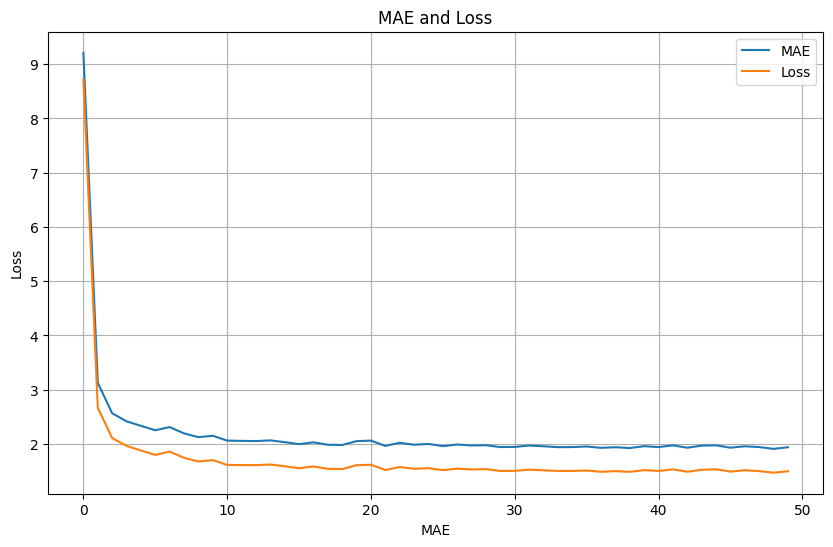

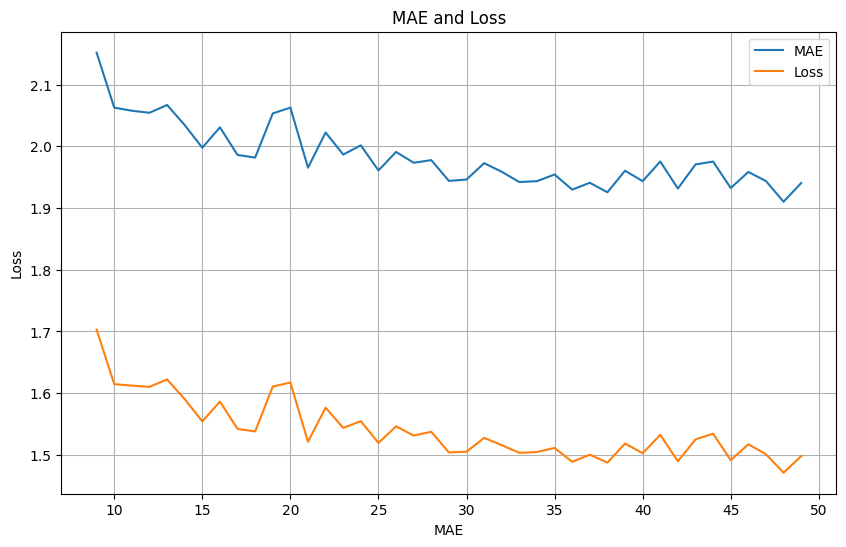

In [42]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [43]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mse(true_series, forecast).numpy()
    mae = tf.keras.metrics.mae(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

In the previous week you saw a faster approach compared to using a for loop to compute the forecasts for every point in the sequence. Remember that this faster approach uses batches of data. 

The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [44]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Now compute the actual forecast:

**Note:** Don't modify the cell below. 

The grader uses the same slicing to get the forecast so if you change the cell below you risk having issues when submitting your model for grading.

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


2024-07-13 14:56:05.109836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1000x600 with 0 Axes>

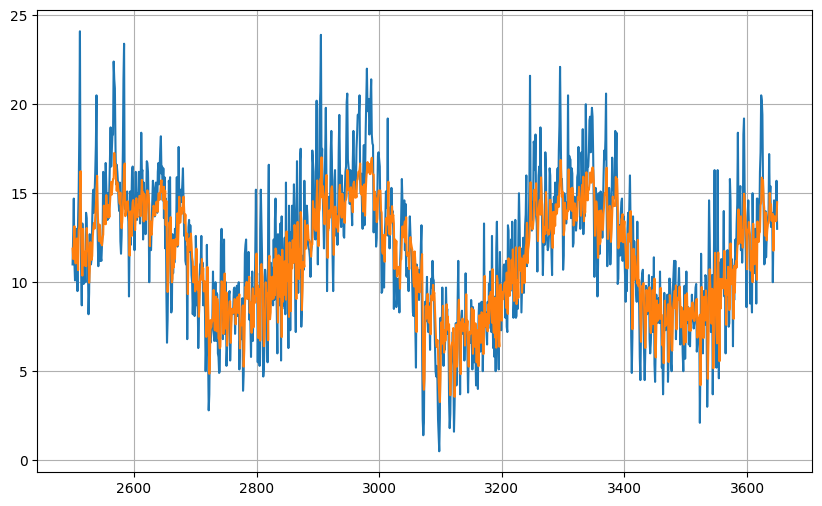

In [50]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, (series_valid,rnn_forecast))
#plot_series(time_valid, rnn_forecast)

In [46]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.46, mae: 1.82 for forecast


**To pass this assignment your forecast should achieve a MSE of 6 or less and a MAE of 2 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save the model in the SavedModel format which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy SavedModel directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**

In [49]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_model/my_model.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging a combination of Tensorflow's layers such as Convolutional and LSTMs! This resulted in a forecast that surpasses all the ones you did previously.

**By finishing this assignment you have finished the specialization! Give yourself a pat on the back!!!**